Import der benötigten Module. Das Modul "ecgdetectors" wird zuerst heruntergeladen und installiert.

In [ ]:
pip install keras-tuner


In [2]:
from google.colab import files
import csv
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from scipy.signal import butter, filtfilt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.preprocessing import normalize
from keras.utils import np_utils
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import tensorflow as tf
import keras_tuner as kt
from sklearn.utils import class_weight
import seaborn as sns
import os
import pickle
import json
import tempfile
nb_classes = 2

Upload-Dialog, um die EKG-Daten in die virtuelle Maschine zu laden und zu entpacken (es erfolgt keine Prüfung, ob die richtige Datei hochgeladen wurde)

In [ ]:
uploaded = files.upload()
!unzip training.zip

Alternative: direkter Download aus Google Drive (deutlich schneller)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/My Drive/X_train_std.pkl" .
!cp "/content/drive/My Drive/X_val_std.pkl" .
!cp "/content/drive/My Drive/Y_train.pkl" .
!cp "/content/drive/My Drive/Y_val.pkl" .
!cp "/content/drive/My Drive/X_train_fft.pkl" .
!cp "/content/drive/My Drive/X_val_fft.pkl" .
!cp "/content/drive/My Drive/tuner_summary.json" .
# !cp "/content/drive/My Drive/sdnn_afib.pkl" .
# !cp "/content/drive/My Drive/sdnn_normal.pkl" .
#!cp "/content/drive/My Drive/training.zip" .
#!unzip training.zip

In [4]:
with open('X_train_std.pkl', 'rb') as f:
    X_train_std = pickle.load(f)
with open('X_val_std.pkl', 'rb') as f:
    X_val_std = pickle.load(f)
with open('Y_train.pkl', 'rb') as f:
    Y_train = pickle.load(f)
with open('Y_val.pkl', 'rb') as f:
    Y_val = pickle.load(f)
with open('X_train_fft.pkl', 'rb') as f:
    X_train_fft = pickle.load(f)
with open('X_val_fft.pkl', 'rb') as f:
    X_val_fft = pickle.load(f)

In [ ]:
with open('sdnn_normal.pkl', 'rb') as f:
    sdnn_normal = pickle.load(f)
with open('sdnn_afib.pkl', 'rb') as f:
    sdnn_afib = pickle.load(f)

# Run to get ECG Data from Zip File into Numpy Array

In [ ]:
def data_preprocessing_short(ecg_lead):
        desired_length=3000
        amount_data, remainder=divmod(ecg_lead.shape[0],desired_length)
        if remainder!=0:
          # Loop the remainder part until it has the desired length
          looped_remainder = np.tile(ecg_lead[desired_length*amount_data:], (desired_length // remainder + 1))[:desired_length]
          # Attach the looped remainder back to the ecg_lead
          ecg_array_processed = np.concatenate((ecg_lead[0:desired_length*amount_data], looped_remainder))
          amount_data+=1
          return ecg_array_processed,amount_data     
        else:
          return ecg_lead,amount_data

In [ ]:
sdnn_normal = np.array([])                              # Initialisierung der Feature-Arrays
sdnn_afib = np.array([])
ecg_class = np.array([])
with open('training/REFERENCE.csv') as csv_file:      # Einlesen der Liste mit Dateinamen und Zuordnung
    csv_reader = csv.reader(csv_file, delimiter=',')
    normal_line_count = 0
    afib_line_count = 0
    desired_length=3000
    for row in csv_reader:
      data = sio.loadmat('training/'+row[0]+'.mat')   # Import der EKG-Dateien
      ecg_lead = data['val'][0]
      ecg_array_processed, amount_data= data_preprocessing_short(ecg_lead) #data preprocessing 0=fill with zero 1=fill with mean 2=loop
      amount_data=np.arange(0,amount_data)
      if row[1] != 'A':                                                   # includes N,O,~
        for i in amount_data: 
          if normal_line_count != 0:                                        #check if its the first time so that vstack can work properly
            sdnn_normal = np.vstack((sdnn_normal,ecg_array_processed[i*desired_length:(i+1)*desired_length]))     
          else:
            sdnn_normal=ecg_array_processed[0:desired_length]
          normal_line_count = normal_line_count + 1    
      if row[1]=='A':
        for i in amount_data:                                                     # Zuordnung zu "Vorhofflimmern"          
          if afib_line_count != 0:                                          #check if its the first time so that vstack can work properly
            sdnn_afib = np.vstack((sdnn_afib,ecg_array_processed[i*desired_length:(i+1)*desired_length]))     
          else:
            sdnn_afib=ecg_array_processed[0:desired_length]                              
          afib_line_count = afib_line_count + 1


In [ ]:
with open('sdnn_normal.pkl', 'wb') as f:
    pickle.dump(sdnn_normal, f)
with open('sdnn_afib.pkl', 'wb') as f:
    pickle.dump(sdnn_afib, f)

# Data Preprocessing

Splitting and Balancing Data

In [6]:
#split data for testing and training
X_train_normal, X_test_normal = train_test_split(sdnn_normal, test_size=0.2, random_state=4)
X_train_afib, X_test_afib = train_test_split(sdnn_afib, test_size=0.2, random_state=4)

####Data Augmentation
stretch_min=1.1
stretch_max=2.5
augmentation_factor=5
#stretch normal ecg
X_train_normal_length=len(X_train_normal)
stretch = np.arange(stretch_min,stretch_max,0.1)
stretch_choices = np.random.choice(stretch, X_train_normal_length*augmentation_factor)
X_train_normal_stretch = np.empty((len(stretch_choices), 3000 ))
index = np.arange(len(stretch_choices))
for i in index:
    stretch_length = int(len(X_train_normal[i%X_train_normal_length,:]) * stretch_choices[i])
    positions=np.arange(len(X_train_normal[i%X_train_normal_length,:]))
    new_positions = np.linspace(0, len(X_train_normal[i%X_train_normal_length,:]), stretch_length)
    X_train_normal_stretch[i,:] = np.interp(new_positions, positions, X_train_normal[i%X_train_normal_length,:])[0:3000]
X_train_normal=X_train_normal_stretch
#sretch afib ecg
X_train_afib_length=len(X_train_afib)
stretch = np.arange(stretch_min,stretch_max,0.1)
stretch_choices = np.random.choice(stretch, X_train_afib_length*augmentation_factor)
X_train_afib_stretch = np.empty((len(stretch_choices), 3000 ))
index = np.arange(len(stretch_choices))
for i in index:
    stretch_length = int(len(X_train_afib[i%X_train_afib_length,:]) * stretch_choices[i])
    positions=np.arange(len(X_train_afib[i%X_train_afib_length,:]))
    new_positions = np.linspace(0, len(X_train_normal[i%X_train_afib_length,:]), stretch_length)
    X_train_afib_stretch[i,:] = np.interp(new_positions, positions, X_train_afib[i%X_train_afib_length,:])[0:3000]
X_train_afib=X_train_afib_stretch
#balance the training dataset without getting test data into the training data 
ids = np.arange(len(X_train_afib))
choices = np.random.choice(ids, len(X_train_normal))
X_train_afib_balanced = X_train_afib[choices]

#balance the test dataset without getting test data into the training data 
ids = np.arange(len(X_test_afib))
choices = np.random.choice(ids, len(X_test_normal))
X_test_afib_balanced = X_test_afib[choices]

#train class
normal_class_train=np.zeros(X_train_normal.shape[0])       
normal_class_train.fill(0)
afib_class_train=np.zeros(X_train_afib_balanced.shape[0])
afib_class_train.fill(1)

#test class
normal_class_test=np.zeros(X_test_normal.shape[0])       
normal_class_test.fill(0)
afib_class_test=np.zeros(X_test_afib_balanced.shape[0])
afib_class_test.fill(1)

#combine train and test set
X_train=np.concatenate((X_train_normal, X_train_afib_balanced))
y_train=np.concatenate((normal_class_train, afib_class_train))

X_val=np.concatenate((X_test_normal, X_test_afib_balanced))
y_val=np.concatenate((normal_class_test, afib_class_test))

#shuffle train 
order = np.arange(len(X_train))
np.random.shuffle(order)
X_train = X_train[order]
y_train = y_train[order]
#shuffle test
order = np.arange(len(X_val))
np.random.shuffle(order)
X_val = X_val[order]
y_val = y_val[order]
#convert for NN
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_val = np_utils.to_categorical(y_val, nb_classes)


In [6]:
X_trainplt=X_train
X_valplt=X_val


In [ ]:
X_train=X_trainplt
X_val=X_valplt

In [7]:
sampling_freq = 300 # Hz
fft_size = len(X_train[0])
# Create a pre-allocated numpy array to store the FFTs of the time series in X_train
X_train_fft = np.empty((len(X_train), fft_size // 2 ))
X_val_fft = np.empty((len(X_val), fft_size // 2 ))

index = []
# Iterate over each time series in X_train and compute its FFT
for i, series in enumerate(X_train):
    fft_results = np.fft.fft(X_train[i,:], fft_size)
    # Only save the positive half of the FFT results
    X_train_fft[i,:] = fft_results[:fft_size // 2]
    # Cumulatively sum
    cumulative_sum = np.cumsum(abs(X_train_fft[i,:]))
    # Find the threshold value at which 99% of the power has been accumulated
    threshold = 0.99 * sum(abs(X_train_fft[i,:]))
    # Find the index of the first value in the cumulative sum that is greater than the threshold
    index =np.append(index,np.argwhere(cumulative_sum > threshold).flatten()[0])

#calculate cutoff frequency at which 99% of information is contained
f_cutoff=sum(index)/len(index)
cutoff_frequency=int(f_cutoff*0.1)

for i, series in enumerate(X_val):
    fft_results = np.fft.fft(X_val[i,:], fft_size)
    # Only save the positive half of the FFT results
    X_val_fft[i,:] = fft_results[:fft_size // 2]



#Cut FFT at that frequency
X_train_fft=X_train_fft[:,0:int(f_cutoff)]
X_val_fft=X_val_fft[:,0:int(f_cutoff)]

<ipython-input-7-fcc56893d83a>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  X_train_fft[i,:] = fft_results[:fft_size // 2]
<ipython-input-7-fcc56893d83a>:27: ComplexWarning: Casting complex values to real discards the imaginary part
  X_val_fft[i,:] = fft_results[:fft_size // 2]


In [ ]:
def plot_fft(X_train):
    # Get the number of time series
    n_time_series = X_train.shape[0]
    # Create a figure with n_time_series subplots
    fig, axs = plt.subplots(n_time_series, figsize=(10, 20))
    # Plot each time series in a separate subplot
    for i in range(n_time_series):
        axs[i].plot(X_train[i])
    # Show the plots
    plt.show()

# Plot the time series
plot_fft(abs(X_train_fft[30:40,:]))

# # Plot a single time series
# # Calculate the frequency axis of the FFT
# freq_axis = np.fft.fftfreq(len(X_train[0]), d=1/sampling_freq)
# freq_axis = freq_axis[:int(f_cutoff)]

# plt.plot(freq_axis, abs(X_train_fft[35]))
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Amplitude ')
# plt.show()

In [8]:
def butterworth_filter(time_series, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_time_series = filtfilt(b, a, time_series)
    return filtered_time_series

index=np.arange(0,X_train.shape[0])
for i in index:
  X_train[i,:] = butterworth_filter(X_train[i,:], lowcut=1.5, highcut=cutoff_frequency, fs=300, order=2)

index=np.arange(0,X_val.shape[0])
for i in index:
  X_val[i,:] = butterworth_filter(X_val[i,:], lowcut=1.5, highcut=cutoff_frequency, fs=300, order=2)

#clip to get rid of outliers
X_train = np.clip(X_train, -500, 500)
X_val = np.clip(X_val, -500, 500)
#standardize the data
std_slc = StandardScaler()
std_slc.fit(X_train)
X_train_std = std_slc.transform(X_train)
X_val_std = std_slc.transform(X_val)
#save slc for predictions
#pickle.dump(std_slc, open('/content/drive/My Drive/scaler.pkl','wb'))

print('Training labels shape:', Y_train.shape)
print('Validation labels shape:', Y_val.shape)
#print('Test labels shape:', test_labels.shape)

print('Training features shape:', X_train_std.shape)
print('Validation features shape:', X_val_std.shape)
#print('Test features shape:', test_features.shape)



print('max value:',np.amax(X_train_std))
print('mean value:',np.mean(X_train_std))
print('min value:',np.amin(X_train_std))


#calculate the class imbalance
sum_class1=Y_train[0:Y_train.shape[0],0]==1
sum_class2=Y_train[0:Y_train.shape[0],1]==1
sum_class1=sum_class1.sum()
sum_class2=sum_class2.sum()
total=sum_class1+sum_class2
print('Training Data:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, sum_class2, 100 * sum_class2 / total))

#calculate the class imbalance
sum_class1=Y_val[0:Y_val.shape[0],0]==1
sum_class2=Y_val[0:Y_val.shape[0],1]==1
sum_class1=sum_class1.sum()
sum_class2=sum_class2.sum()
total=sum_class1+sum_class2

print('Validation Data:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, sum_class2, 100 * sum_class2 / total))
   
# weight_for_0 = (1 / sum_class1) * (total / 2.0)
# weight_for_1 = (1 / sum_class2) * (total / 2.0)

# class_weight = {0: weight_for_0,
#                 1: weight_for_1
#                 }

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))




Training labels shape: (148090, 2)
Validation labels shape: (7406, 2)
Training features shape: (148090, 3000)
Validation features shape: (7406, 3000)
max value: 8.339039
mean value: 6.4827614e-12
min value: -8.340937
Training Data:
    Total: 148090
    Positive: 74045 (50.00% of total)

Validation Data:
    Total: 7406
    Positive: 3703 (50.00% of total)



Plot ECG Data

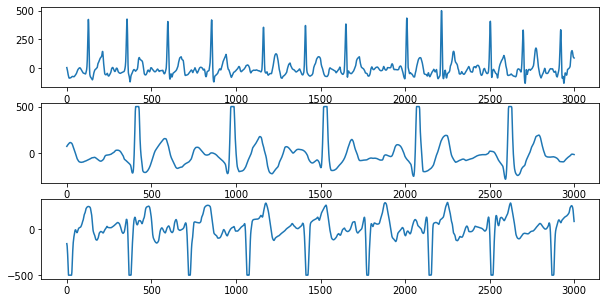

In [112]:
def plot_time_series(X_train):
    # Get the number of time series
    n_time_series = X_train.shape[0]
    # Create a figure with n_time_series subplots
    fig, axs = plt.subplots(n_time_series, figsize=(10, 5))
    # Plot each time series in a separate subplot
    for i in range(n_time_series):
        axs[i].plot(X_train[i])
    # Show the plots
    plt.show()

# Plot the time series
plot_time_series(X_train[0:2,:])

stretch_min=1.1
stretch_max=2.5
augmentation_factor=5
X_train_length=len(X_train)
stretch = np.arange(stretch_min,stretch_max,0.1)
stretch_choices = np.random.choice(stretch, X_train_length*augmentation_factor)

data_stretch = np.empty((len(stretch_choices), 3000 ))
index = np.arange(len(stretch_choices))
for i in index:
    stretch_length = int(len(X_train[i%X_train_length,:]) * stretch_choices[i])
    positions=np.arange(len(X_train[i%X_train_length,:]))
    new_positions = np.linspace(0, len(X_train[i%X_train_length,:]), stretch_length)
    data_stretch[i,:] = np.interp(new_positions, positions, X_train[i%X_train_length,:])[0:3000]


In [9]:
with open('X_train_std.pkl', 'wb') as f:
    pickle.dump(X_train_std, f)
with open('X_val_std.pkl', 'wb') as f:
    pickle.dump(X_val_std, f)
with open('Y_train.pkl', 'wb') as f:
    pickle.dump(Y_train, f)
with open('Y_val.pkl', 'wb') as f:
    pickle.dump(Y_val, f)
with open('X_train_fft.pkl', 'wb') as f:
    pickle.dump(X_train_fft, f)
with open('X_val_fft.pkl', 'wb') as f:
    pickle.dump(X_val_fft, f)

Hypermodel

In [5]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      keras.metrics.BinaryAccuracy(name='binary_accuracy')
]
def model_builder(hp):
##input time series X_train
  input_1 = keras.layers.Input(shape=[3000, 1])

  conv_1 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(input_1)
  batch_norm_1 = layers.BatchNormalization()(conv_1)
  conv_2 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_1)
  max_pool_1 = keras.layers.MaxPool1D(pool_size=4)(conv_2)

  batch_norm_2 = layers.BatchNormalization()(max_pool_1)
  conv_3 = keras.layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_2)
  batch_norm_3 = layers.BatchNormalization()(conv_3)
  conv_4 = keras.layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_3)
  max_pool_2 = keras.layers.MaxPool1D(pool_size=4)(conv_4)

  batch_norm_4 = layers.BatchNormalization()(max_pool_2)
  conv_5 = keras.layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_4)
  batch_norm_5 = layers.BatchNormalization()(conv_5)
  conv_6 = keras.layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_5)
  batch_norm_6 = layers.BatchNormalization()(conv_6)
  conv_7 = keras.layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_6)
  max_pool_3 = keras.layers.MaxPool1D(pool_size=4)(conv_7)

  batch_norm_7 = layers.BatchNormalization()(max_pool_3)
  conv_8 = keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_7)
  batch_norm_8 = layers.BatchNormalization()(conv_8)
  conv_9 = keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_8)
  batch_norm_9 = layers.BatchNormalization()(conv_9)
  conv_10 = keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_9)
  max_pool_4 = keras.layers.MaxPool1D(pool_size=4)(conv_10)

  batch_norm_10 = layers.BatchNormalization()(max_pool_4)
  conv_11 = keras.layers.Conv1D(filters=256, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_10)
  batch_norm_11 = layers.BatchNormalization()(conv_11)
  conv_12 = keras.layers.Conv1D(filters=256, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_11)
  batch_norm_12 = layers.BatchNormalization()(conv_12)
  conv_13 = keras.layers.Conv1D(filters=256, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_12)
  max_pool_3 = keras.layers.MaxPool1D(pool_size=4)(conv_13)

##input fft X_train_fft
  input_2 = keras.layers.Input(shape=[1032, 1])

  fft_conv_1 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(input_2)
  fft_batch_norm_1 = layers.BatchNormalization()(fft_conv_1)
  fft_conv_2 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_1)
  fft_max_pool_1 = keras.layers.MaxPool1D(pool_size=4)(fft_conv_2)

  fft_batch_norm_2 = layers.BatchNormalization()(fft_max_pool_1)
  fft_conv_3 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_2)
  fft_batch_norm_3 = layers.BatchNormalization()(fft_conv_3)
  fft_conv_4 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_3)
  fft_max_pool_2 = keras.layers.MaxPool1D(pool_size=4)(fft_conv_4)

  fft_batch_norm_4 = layers.BatchNormalization()(fft_max_pool_2)
  fft_conv_5 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_4)
  fft_batch_norm_5 = layers.BatchNormalization()(fft_conv_5)
  fft_conv_6 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_5)
  fft_batch_norm_6 = layers.BatchNormalization()(fft_conv_6)
  fft_conv_7 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_6)
  fft_max_pool_3 = keras.layers.MaxPool1D(pool_size=4)(fft_conv_7)

  fft_batch_norm_7 = layers.BatchNormalization()(fft_max_pool_3)
  fft_conv_8 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_7)
  fft_batch_norm_8 = layers.BatchNormalization()(fft_conv_8)
  fft_conv_9 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_8)
  fft_batch_norm_9 = layers.BatchNormalization()(fft_conv_9)
  fft_conv_10 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_9)
  fft_max_pool_4 = keras.layers.MaxPool1D(pool_size=4)(fft_conv_10)

  fft_batch_norm_10 = layers.BatchNormalization()(fft_max_pool_4)
  fft_conv_11 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_10)
  fft_batch_norm_11 = layers.BatchNormalization()(fft_conv_11)
  fft_conv_12 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_11)
  fft_batch_norm_12 = layers.BatchNormalization()(fft_conv_12)
  fft_conv_13 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_12)
  fft_max_pool_3 = keras.layers.MaxPool1D(pool_size=2)(fft_conv_13)

  # Merge the outputs of the two convolutional layers
  merged = keras.layers.Concatenate()([max_pool_3, fft_max_pool_3])
  flatten=keras.layers.Flatten()(merged)
  # Add the rest of the layers to the model
  dense_units_1 = hp.Int('dense_units_1', min_value=256, max_value=1024, step=128)
  dense_reg_1 = hp.Choice('dense_reg_1', values=[1e-2, 1e-3, 1e-4]) 
  dense_batch_norm_1 = layers.BatchNormalization()(flatten)
  dense_1 = keras.layers.Dense(units=dense_units_1, activation='relu',kernel_regularizer=regularizers.l2(dense_reg_1))(dense_batch_norm_1)

  hp_drop_1 = hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)
  dropout_1 = keras.layers.Dropout(hp_drop_1)(dense_1)

  dense_units_2 = hp.Int('dense_units_2', min_value=256, max_value=1024, step=128)
  dense_reg_2 = hp.Choice('dense_reg_2', values=[1e-2, 1e-3, 1e-4]) 
  dense_batch_norm_2 = layers.BatchNormalization()(dropout_1)
  dense_2 = keras.layers.Dense(units=dense_units_2, activation='relu',kernel_regularizer=regularizers.l2(dense_reg_2))(dense_batch_norm_2)

  hp_drop_2 = hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)
  dropout_2 = keras.layers.Dropout(hp_drop_2)(dense_2)
  
  dense_batch_norm_3 = layers.BatchNormalization()(dropout_2)
  output = keras.layers.Dense(2, activation='sigmoid')(dense_batch_norm_3)
  
  # Create the model with two inputs and one output
  model = keras.Model(inputs=[input_1, input_2], outputs=output)


####old model
  # model = keras.Sequential()
  # #1
  # # hp_units_0 = hp.Int('units_0', min_value=24, max_value=88, step=8)
  # # hp_reg_0 = hp.Choice('reg_0', values=[1e-3, 1e-4])
  # model.add(keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=[3000,1]))                                      
  # model.add(layers.BatchNormalization())
  # model.add(keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)))                                      
  # model.add(keras.layers.MaxPool1D(pool_size=4))
  # #2
  # # hp_units_1 = hp.Int('units_1', min_value=24, max_value=88, step=8)
  # # hp_reg_1 = hp.Choice('reg_1', values=[1e-3, 1e-4])
  # model.add(layers.BatchNormalization())
  # model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)))                                      
  # model.add(layers.BatchNormalization())
  # model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)))                                      
  # model.add(keras.layers.MaxPool1D(pool_size=4))
  
  # #3
  # # hp_units_2 = hp.Int('units_2', min_value=24, max_value=88, step=8)
  # # hp_reg_2 = hp.Choice('reg_2', values=[1e-3, 1e-4])
  # model.add(layers.BatchNormalization())
  # model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)))                                      
  # model.add(layers.BatchNormalization())
  # model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)))                                      
  # model.add(layers.BatchNormalization())
  # model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)))                                      
  # model.add(layers.BatchNormalization())
  # model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)))                                      
  # model.add(keras.layers.MaxPool1D(pool_size=4))
  # #4
  # # hp_units_3 = hp.Int('units_3', min_value=24, max_value=88, step=8)
  # # hp_reg_3 = hp.Choice('reg_3', values=[1e-3, 1e-4])
  # model.add(layers.BatchNormalization())
  # model.add(keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)))                                      
  # model.add(layers.BatchNormalization())
  # model.add(keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)))                                      
  # model.add(layers.BatchNormalization())
  # model.add(keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)))                                      
  # model.add(layers.BatchNormalization())
  # model.add(keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)))                                      
  # model.add(keras.layers.MaxPool1D(pool_size=4))
  # #5
  # # hp_units_4 = hp.Int('units_4', min_value=24, max_value=88, step=8)
  # # hp_reg_4 = hp.Choice('reg_4', values=[1e-3, 1e-4])
  # model.add(layers.BatchNormalization())
  # model.add(keras.layers.Conv1D(filters=256, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)))                                      
  # model.add(layers.BatchNormalization())
  # model.add(keras.layers.Conv1D(filters=256, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)))                                      
  # model.add(layers.BatchNormalization())
  # model.add(keras.layers.Conv1D(filters=256, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)))                                      
  # model.add(layers.BatchNormalization())
  # model.add(keras.layers.Conv1D(filters=256, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)))                                      
  # model.add(keras.layers.MaxPool1D(pool_size=4))

  # model.add(keras.layers.Flatten())

  # model.add(layers.BatchNormalization())
  # dense_units_0 = hp.Int('dense_units_0', min_value=128, max_value=512, step=64)
  # dense_reg_0 = hp.Choice('dense_reg_0', values=[1e-2, 1e-3, 1e-4])
  # model.add(keras.layers.Dense(units=dense_units_0, activation='relu',kernel_regularizer=regularizers.l2(dense_reg_0), input_shape=[512]))
  # hp_drop_0 = hp.Float('dropout_0', min_value=0.0, max_value=0.5, step=0.1)
  # model.add(keras.layers.Dropout(hp_drop_0))

  # model.add(layers.BatchNormalization())
  # dense_units_1 = hp.Int('dense_units_1', min_value=128, max_value=512, step=64)
  # dense_reg_1 = hp.Choice('dense_reg_1', values=[1e-2, 1e-3, 1e-4]) 
  # model.add(keras.layers.Dense(units=dense_units_1, activation='relu',kernel_regularizer=regularizers.l2(dense_reg_1)))
  # hp_drop_1 = hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)
  # model.add(keras.layers.Dropout(hp_drop_1))

  # model.add(layers.BatchNormalization())
  # model.add(keras.layers.Dense(2, activation='sigmoid'))


  # Initialize the Sequential API and start stacking the layers
  # model = keras.Sequential()
  # # Tune the number of units in the first Dense layer
  # # Choose an optimal value between 32-512
  # hp_units_0 = hp.Int('units_0', min_value=320, max_value=512, step=32)
  # hp_reg_0 = hp.Choice('reg_0', values=[1e-2, 1e-3, 1e-4])
  # model.add(keras.layers.Dense(units=hp_units_0, activation='relu',kernel_regularizer=regularizers.l2(hp_reg_0), name='dense_first', input_shape=[9000]))

  # model.add(layers.BatchNormalization())

  # # hp_drop = hp.Float('dropout_first', min_value=0.0, max_value=0.7, step=0.1)
  # # model.add(keras.layers.Dropout(hp_drop))

  # # #second dense layer
  # # hp_units_2 = hp.Int('units_2', min_value=320, max_value=512, step=32)
  # # hp_reg_2 = hp.Choice('reg_2', values=[1e-2, 1e-3, 1e-4])
  # # model.add(keras.layers.Dense(units=hp_units_2, activation='relu',kernel_regularizer=regularizers.l2(hp_reg_2), name='dense_2'))

  # # model.add(layers.BatchNormalization())

  # # hp_drop_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.7, step=0.1)
  # # model.add(keras.layers.Dropout(hp_drop_2))

  # # #third dense layer
  # # hp_units_3 = hp.Int('units_3', min_value=320, max_value=512, step=32)
  # # hp_reg_3 = hp.Choice('reg_3', values=[1e-2, 1e-3, 1e-4])
  # # model.add(keras.layers.Dense(units=hp_units_2, activation='relu',kernel_regularizer=regularizers.l2(hp_reg_2), name='dense_3'))

  # # model.add(layers.BatchNormalization())

  # # hp_drop_3 = hp.Float('dropout_3', min_value=0.1, max_value=0.7, step=0.1)
  # # model.add(keras.layers.Dropout(hp_drop_3))
  # # ##dense layer
  # # hp_units_3 = hp.Int('units_3', min_value=32, max_value=512, step=32)
  # # model.add(keras.layers.Dense(units=hp_units_3, activation='relu', name='dense_3'))
  # # hp_drop_3 = hp.Float('dropout_3', min_value=0.1, max_value=0.7, step=0.1)
  # # model.add(keras.layers.Dropout(hp_drop_3))
  # # model.add(layers.BatchNormalization())

  # # for i in range(hp.Int('layers', 2, 6)):
  # #     model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i), 32, 512, step=32),
  # #                                   activation='relu'))
  # #     model.add(keras.layers.Dropout(hp.Float('dropout_'+ str(i), min_value=0.0, max_value=0.5, step=0.1)))
  # #     model.add(layers.BatchNormalization())

  # model.add(keras.layers.Dense(2, activation='sigmoid'))
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  #########################
  #   model = keras.Sequential([

  #     # First Convolutional Block
  #     layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.01),  
  #                   # give the input dimensions in the first layer
  #                   input_shape=[9000,1]),                                       
  #     layers.MaxPool1D(),#4500,16

  #     # Second Convolutional Block
  #     layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.01)),
  #     layers.BatchNormalization(),
  #     layers.MaxPool1D(),#2250,32

  #     # Third Convolutional Block
  #     layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.01)),
  #     layers.BatchNormalization(),
  #     layers.MaxPool1D(),#1125,64

  #     # Forth Convolutional Block
  #     layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.01)),
  #     layers.BatchNormalization(),
  #     layers.MaxPool1D(),#563,64

  #     # Forth Convolutional Block
  #     layers.Conv1D(filters=8, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.01)),
  #     layers.BatchNormalization(),
  #     layers.MaxPool1D(),#282,2

  #     # Forth Convolutional Block
  #     layers.Conv1D(filters=8, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.01)),
  #     layers.BatchNormalization(),
  #     layers.MaxPool1D(),#141,2

  #     # Forth Convolutional Block
  #     layers.Conv1D(filters=4, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.01)),
  #     layers.BatchNormalization(),
  #     layers.MaxPool1D(),#71,2
  #     # Forth Convolutional Block
  #     layers.Conv1D(filters=2, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.01)),
  #     layers.BatchNormalization(),
  #     layers.MaxPool1D(),#71,2

  #     # Classifier Head
  #     layers.Flatten(),
  #     layers.Dense(16, activation='relu', input_shape=[70],kernel_regularizer=regularizers.l2(0.01)),                   #dense layer sizes could probably be chosen better
  #     layers.BatchNormalization(),
  #     layers.Dropout(0.5),
  #     layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.01)),    
  #     layers.BatchNormalization(),
  #     layers.Dropout(0.5),
  #     layers.Dense(2, activation='sigmoid'),
  # ])
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='binary_crossentropy',
                metrics=METRICS)
  return model

# Instantiate the tuner
#tuner.objective("prc", direction="max")
tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective=kt.Objective('val_loss', direction='min'),
                     max_epochs=32,
                     factor=2, # factor which you have seen above 
                     directory='dir', # directory to save logs 
                     project_name='khyperband'
                     )
tuner.overwrite=True
# hypertuning settings
tuner.search_space_summary() 

Search space summary
Default search space size: 7
dense_units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 1024, 'step': 128, 'sampling': None}
dense_reg_1 (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
dense_units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 1024, 'step': 128, 'sampling': None}
dense_reg_2 (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [12]:
%rm -rf dir

if you want to continue from a previous tuner search

In [ ]:
# Continue the tuning process from the last completed trial
with open('tuner_summary.json', 'r') as f:
  summary = json.load(f)

Start Keras Tuner Search

In [ ]:
#save progress after every 10 trials
class SaveSummary(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    # Save the summary only after every 10 trials
    if epoch % 10 == 0:
      summary = tuner.results_summary()
      # Save the progress of the Hyperband object
      with open('/content/drive/My Drive/tuner_summary.json', 'w') as f:
        json.dump(summary, f)
#stop trial if there is no progress
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

callbacks = [SaveSummary(), stop_early]

# Perform hypertuning
tuner.search((X_train_std,X_train_fft), Y_train, epochs=50, validation_data=((X_val_std,X_val_fft), Y_val), batch_size=128,callbacks=callbacks
             #,class_weight=class_weight
             )
tuner.results_summary()

Trial 96 Complete [00h 04m 24s]
val_loss: 0.46274006366729736

Best val_loss So Far: 0.41774988174438477
Total elapsed time: 03h 39m 52s

Search: Running Trial #97

Value             |Best Value So Far |Hyperparameter
384               |384               |dense_units_1
0.0001            |0.0001            |dense_reg_1
0.4               |0.5               |dropout_1
256               |384               |dense_units_2
0.001             |0.001             |dense_reg_2
0.1               |0.1               |dropout_2
0.01              |0.001             |learning_rate
8                 |2                 |tuner/epochs
4                 |1                 |tuner/initial_epoch
4                 |5                 |tuner/bracket
2                 |1                 |tuner/round
0086              |0016              |tuner/trial_id

Epoch 5/8
1157/1157 [==============================] - 73s 55ms/step - loss: 0.5099 - tp: 135349.0000 - fp: 20209.0000 - tn: 135287.0000 - fn: 20147.0000 - accuracy:

In [ ]:
# Build the model with the optimal hyperparameters
best_hp=tuner.get_best_hyperparameters()[0]
#print(best_hp.get('units'))
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()
history=h_model.fit(X_train_std, Y_train, epochs=100, validation_data=(X_val_std, Y_val)
                    #,class_weight=class_weight
                    )

# #determine best epoch
# val_acc_per_epoch = history.history['val_recall']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch,))

NameError: ignored

In [ ]:
print(Y_val)
print(Y_val.argmax(axis=1))
test_predictions_baseline = h_model.predict(X_val_std,verbose=0)
print(test_predictions_baseline)
print(test_predictions_baseline.argmax(axis=1))

loss :  0.3891448676586151
tp :  1339.0
fp :  89.0
tn :  1339.0
fn :  89.0
accuracy :  0.9376750588417053
precision :  0.9376750588417053
recall :  0.9376750588417053
auc :  0.9797634482383728
prc :  0.9762308597564697
binary_accuracy :  0.9376750588417053

Normal ECG Detected (True Negatives):  1260
Normal ECG Incorrectly Detected (False Positives):  46
AFIB ECG Missed (False Negatives):  43
AFIB ECG Detected (True Positives):  79
Total ECG AFIB:  122
Best epoch: 8


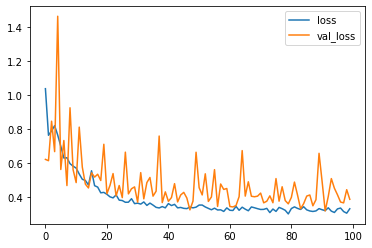

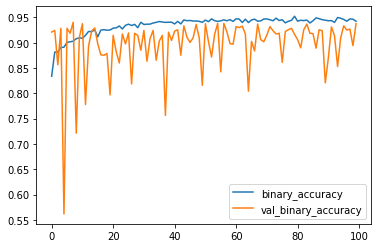

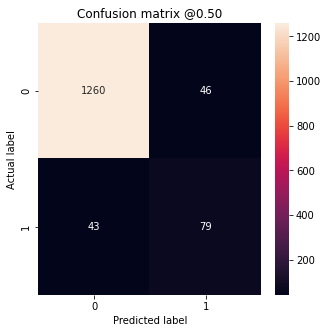

In [ ]:
#plot loss
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

#Confusion Matrix
train_predictions_baseline = h_model.predict(X_train_std,verbose=0)
test_predictions_baseline = h_model.predict(X_val_std,verbose=0)

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Normal ECG Detected (True Negatives): ', cm[0][0])
  print('Normal ECG Incorrectly Detected (False Positives): ', cm[0][1])
  print('AFIB ECG Missed (False Negatives): ', cm[1][0])
  print('AFIB ECG Detected (True Positives): ', cm[1][1])
  print('Total ECG AFIB: ', np.sum(cm[1]))

baseline_results = h_model.evaluate(X_val_std, Y_val,verbose=0)
for name, value in zip(h_model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(Y_val.argmax(axis=1), test_predictions_baseline.argmax(axis=1))

#plot_cm(Y_train.argmax(axis=1), train_predictions_baseline.argmax(axis=1))

# #determine best epoch
val_acc_per_epoch = history.history['val_loss']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [20]:
# pretrained_base = tf.keras.models.load_model(
#     '../input/cv-course-models/cv-course-models/vgg16-pretrained-base',
# )
# pretrained_base.trainable = False


# model = keras.Sequential([
#     pretrained_base,
#     layers.Flatten(),
#     layers.Dense(6, activation='relu'),
#     layers.Dense(1, activation='sigmoid'),
# ])
##########Dense Model############
#set initial bias to reflect the class imbalance to speed up learning
#output_bias= None
#set intial Bias
# output_bias = np.log([sum_class2/sum_class1])
# output_bias = tf.keras.initializers.Constant(output_bias)

# model = keras.Sequential([
#     layers.Dense(25, activation='relu', input_shape=[9000]),
#     layers.Dropout(0.3),
#     layers.BatchNormalization(),
#     layers.Dense(25, activation='relu'),
#     layers.Dropout(0.3),
#     layers.BatchNormalization(),
#     layers.Dense(2, activation='sigmoid',bias_initializer=output_bias),
# ])
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      keras.metrics.BinaryAccuracy(name='binary_accuracy')
]
# def make_model(metrics=METRICS, output_bias=None):
#   if output_bias is not None:
#     output_bias = tf.keras.initializers.Constant(output_bias)
#   model = keras.Sequential([
#       layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),input_shape=(9000,)),
#       layers.BatchNormalization(),
#       layers.Dropout(0.5),
#       # layers.Dense(2048, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
#       # layers.BatchNormalization(),
#       # layers.Dropout(0.5),
#       # layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
#       # layers.BatchNormalization(),
#       # layers.Dropout(0.5),
#       # layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
#       # layers.BatchNormalization(),
#       # layers.Dropout(0.5),
#       # layers.Dense(192, activation='relu'),
#       # layers.BatchNormalization(),
#       # layers.Dropout(0.2),
#       # layers.Dense(320, activation='relu'),
#       # layers.BatchNormalization(),
#       # layers.Dropout(0.2),
#       # layers.Dense(32, activation='relu'),
#       # layers.BatchNormalization(),
#       # layers.Dropout(0.3),
#       layers.Dense(2, activation='sigmoid',
#                          #bias_initializer=output_bias
#                          ),
#   ])

#   model.compile(
#       optimizer=keras.optimizers.Adam(learning_rate=1e-3),
#       loss=keras.losses.BinaryCrossentropy(),
#       metrics=metrics)

#   return model
################CNN###################
def make_model(metrics=METRICS, output_bias=None):
####input time series X_train
  input_1 = keras.layers.Input(shape=[3000, 1])
  ##strides=2, halfes the output shape
  conv_1 = keras.layers.Conv1D(filters=16, kernel_size=3,activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(input_1)
  batch_norm_1 = layers.BatchNormalization()(conv_1)
  conv_2 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_1)
  max_pool_1 = keras.layers.MaxPool1D(pool_size=4)(conv_2)

  batch_norm_2 = layers.BatchNormalization()(max_pool_1)
  conv_3 = keras.layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_2)
  batch_norm_3 = layers.BatchNormalization()(conv_3)
  conv_4 = keras.layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_3)
  max_pool_2 = keras.layers.MaxPool1D(pool_size=4)(conv_4)

  batch_norm_4 = layers.BatchNormalization()(max_pool_2)
  conv_5 = keras.layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_4)
  batch_norm_5 = layers.BatchNormalization()(conv_5)
  conv_6 = keras.layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_5)
  batch_norm_6 = layers.BatchNormalization()(conv_6)
  conv_7 = keras.layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_6)
  max_pool_3 = keras.layers.MaxPool1D(pool_size=4)(conv_7)

  batch_norm_7 = layers.BatchNormalization()(max_pool_3)
  conv_8 = keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_7)
  batch_norm_8 = layers.BatchNormalization()(conv_8)
  conv_9 = keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_8)
  batch_norm_9 = layers.BatchNormalization()(conv_9)
  conv_10 = keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_9)
  max_pool_4 = keras.layers.MaxPool1D(pool_size=4)(conv_10)

  batch_norm_10 = layers.BatchNormalization()(max_pool_4)
  conv_11 = keras.layers.Conv1D(filters=256, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_10)
  batch_norm_11 = layers.BatchNormalization()(conv_11)
  conv_12 = keras.layers.Conv1D(filters=256, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_11)
  batch_norm_12 = layers.BatchNormalization()(conv_12)
  conv_13 = keras.layers.Conv1D(filters=256, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(batch_norm_12)
  max_pool_3 = keras.layers.MaxPool1D(pool_size=4)(conv_13)

####input fft X_train_fft
  input_2 = keras.layers.Input(shape=[1032, 1])

  fft_conv_1 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(input_2)
  fft_batch_norm_1 = layers.BatchNormalization()(fft_conv_1)
  fft_conv_2 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_1)
  fft_max_pool_1 = keras.layers.MaxPool1D(pool_size=4)(fft_conv_2)

  fft_batch_norm_2 = layers.BatchNormalization()(fft_max_pool_1)
  fft_conv_3 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_2)
  fft_batch_norm_3 = layers.BatchNormalization()(fft_conv_3)
  fft_conv_4 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_3)
  fft_max_pool_2 = keras.layers.MaxPool1D(pool_size=4)(fft_conv_4)

  fft_batch_norm_4 = layers.BatchNormalization()(fft_max_pool_2)
  fft_conv_5 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_4)
  fft_batch_norm_5 = layers.BatchNormalization()(fft_conv_5)
  fft_conv_6 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_5)
  fft_batch_norm_6 = layers.BatchNormalization()(fft_conv_6)
  fft_conv_7 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_6)
  fft_max_pool_3 = keras.layers.MaxPool1D(pool_size=4)(fft_conv_7)

  fft_batch_norm_7 = layers.BatchNormalization()(fft_max_pool_3)
  fft_conv_8 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_7)
  fft_batch_norm_8 = layers.BatchNormalization()(fft_conv_8)
  fft_conv_9 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_8)
  fft_batch_norm_9 = layers.BatchNormalization()(fft_conv_9)
  fft_conv_10 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_9)
  fft_max_pool_4 = keras.layers.MaxPool1D(pool_size=4)(fft_conv_10)

  fft_batch_norm_10 = layers.BatchNormalization()(fft_max_pool_4)
  fft_conv_11 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_10)
  fft_batch_norm_11 = layers.BatchNormalization()(fft_conv_11)
  fft_conv_12 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_11)
  fft_batch_norm_12 = layers.BatchNormalization()(fft_conv_12)
  fft_conv_13 = keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same', kernel_regularizer=regularizers.l2(0.0001))(fft_batch_norm_12)
  fft_max_pool_3 = keras.layers.MaxPool1D(pool_size=2)(fft_conv_13)

  # Merge the outputs of the two convolutional layers
  merged = keras.layers.Concatenate()([max_pool_3, fft_max_pool_3])
  flatten=keras.layers.Flatten()(merged)

  # flat_max_pool_3 = keras.layers.Flatten()(max_pool_3)
  # flat_fft_max_pool_3 = keras.layers.Flatten()(fft_max_pool_3)
  # # Concatenate the flattened layers
  # flatten = keras.layers.Concatenate()([flat_max_pool_3, flat_fft_max_pool_3])

  # Add the rest of the layers to the model
  dense_batch_norm_1 = layers.BatchNormalization()(flatten)
  dense_1 = keras.layers.Dense(units=384, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(dense_batch_norm_1)
  dropout_1 = keras.layers.Dropout(0.4)(dense_1)

  dense_batch_norm_2 = layers.BatchNormalization()(dropout_1)
  dense_2 = keras.layers.Dense(units=256, activation='relu',kernel_regularizer=regularizers.l2(0.001))(dense_batch_norm_2)
  dropout_2 = keras.layers.Dropout(0.1)(dense_2)

  dense_batch_norm_3 = layers.BatchNormalization()(dropout_2)
  output = keras.layers.Dense(2, activation='sigmoid')(dense_batch_norm_3)
  
  # Create the model with two inputs and one output
  model = keras.Model(inputs=[input_1, input_2], outputs=output)

  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics)
  
  return model
#################old model without fft#####################
# def make_model(metrics=METRICS, output_bias=None):
#   model = keras.Sequential([

#       # First Convolutional Block
#       layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001),  
#                     # give the input dimensions in the first layer
#                     input_shape=[3000,1]),   
#       layers.BatchNormalization(),
#       layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)),                                          
#       layers.MaxPool1D(pool_size=4),#750

#       # Second Convolutional Block
#       layers.BatchNormalization(),
#       layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)),
#       layers.BatchNormalization(),
#       layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)),
#       layers.MaxPool1D(pool_size=4),#187

#       # Third Convolutional Block
#       layers.BatchNormalization(),
#       layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)),
#       layers.BatchNormalization(),
#       layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)),
#       layers.BatchNormalization(),
#       layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)),
#       layers.BatchNormalization(),
#       layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)),
#       layers.MaxPool1D(pool_size=4),#46

#       # Forth Convolutional Block
#       layers.BatchNormalization(),
#       layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)),
#       layers.BatchNormalization(),
#       layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)),
#       layers.BatchNormalization(),
#       layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)),
#       layers.BatchNormalization(),
#       layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)),
#       layers.MaxPool1D(pool_size=4),#11

#       # Forth Convolutional Block
#       layers.BatchNormalization(),
#       layers.Conv1D(filters=256, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)),
#       layers.BatchNormalization(),
#       layers.Conv1D(filters=256, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)),
#       layers.BatchNormalization(),
#       layers.Conv1D(filters=256, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)),
#       layers.BatchNormalization(),
#       layers.Conv1D(filters=256, kernel_size=3, activation="relu", padding='same',kernel_regularizer=regularizers.l2(0.0001)),
#       layers.MaxPool1D(pool_size=4),#2

#       # Classifier Head
#       layers.Flatten(),
#       layers.Dense(128, activation='relu', input_shape=[512],kernel_regularizer=regularizers.l2(0.0001)),             
#       layers.BatchNormalization(),
#       layers.Dropout(0.3),
#       layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)),    
#       layers.BatchNormalization(),
#       #layers.Dropout(0.5),
#       layers.Dense(2, activation='sigmoid'),
#   ])

#   model.compile(
#       optimizer=keras.optimizers.Adam(learning_rate=1e-2),
#       loss=keras.losses.BinaryCrossentropy(),
#       metrics=metrics)

#   return model

##################Autoencoder#######################
# model = keras.Sequential([
#     #Encoder
#     # First Convolutional Block
#     layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same',   #9000,32
#                   input_shape=[9000,1]),                                        
#     layers.MaxPool1D(2,padding='same'),#4500,32
#     layers.BatchNormalization(),  
#     # Second Convolutional Block
#     layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same'),#4500,16
#     layers.MaxPool1D(2,padding='same'),#2250,16
#     layers.BatchNormalization(),  

#     # Third Convolutional Block
#     layers.Conv1D(filters=8, kernel_size=3, activation="relu", padding='same'),#2250,8
#     layers.MaxPool1D(2,padding='same'),#1125,8
#     layers.BatchNormalization(),  

#     #Decoder
#     layers.Conv1D(filters=8, kernel_size=3, activation="relu", padding='same'),#1125,8
#     layers.UpSampling1D(2),#2250,8
#     layers.BatchNormalization(),  

#     layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same'),#2250,16
#     layers.UpSampling1D(2),#4500,16
#     layers.BatchNormalization(),  

#     layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same'),#4500,32
#     layers.UpSampling1D(2),#9000,32
#     layers.BatchNormalization(),  

#     layers.Conv1D(filters=1, kernel_size=3, activation="relu", padding='same'),#9000,1
# ])


In [21]:
#####################Autoencoder#################################
# model.compile(
#     optimizer='adam',
#     loss='mean_squared_error',
#     metrics=['mean_absolute_percentage_error'],
# )

# history = model.fit(
#     X_train_std, X_train_std,
#     validation_data=(X_val_std, X_val_std),
#     epochs=30,
#     verbose=1,
# )

# history_frame = pd.DataFrame(history.history)
# history_frame.loc[:, ['loss', 'val_loss']].plot()
# history_frame.loc[:, ['mean_absolute_percentage_error', 'val_mean_absolute_percentage_error']].plot();

#################For CNN or Dense Model#########################
#show model architecture
# METRICS = [
#       keras.metrics.TruePositives(name='tp'),
#       keras.metrics.FalsePositives(name='fp'),
#       keras.metrics.TrueNegatives(name='tn'),
#       keras.metrics.FalseNegatives(name='fn'), 
#       keras.metrics.BinaryAccuracy(name='accuracy'),
#       keras.metrics.Precision(name='precision'),
#       keras.metrics.Recall(name='recall'),
#       keras.metrics.AUC(name='auc'),
#       keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
#       keras.metrics.BinaryAccuracy(name='binary_accuracy')
# ]

# model.compile(
#     optimizer='adam',
#     loss='binary_crossentropy',
#     metrics=METRICS,
# )
#set intial Bias to reflect unbalanced dataset
#initial_bias = np.log([sum_class2/sum_class1])

#load same weights for every model to make them comparable
model = make_model()
model.summary()
#early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=20, # number of epochs that didnt bring an improvement 
    mode='min',
    restore_best_weights=True)
#safe best model after every epoch
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    (X_train_std,X_train_fft), Y_train,
    validation_data=((X_val_std,X_val_fft), Y_val),
    epochs=100,
    #callbacks=[early_stopping],
    callbacks=[checkpoint],
    #class_weight=class_weight,
    # batch_size=BATCH_SIZE,  
    verbose=1,
)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# def plot_loss(history, label, n):
#   # Use a log scale on y-axis to show the wide range of values.
#   plt.semilogy(history.epoch, history.history['loss'],
#                color=colors[n], label='Train ' + label)
#   plt.semilogy(history.epoch, history.history['val_loss'],
#                color=colors[n], label='Val ' + label,
#                linestyle="--")
#   plt.xlabel('Epoch')
#   plt.ylabel('Loss')
# plot_loss(history, "Zero Bias", 0)

# #determine best epoch
val_acc_per_epoch = history.history['val_binary_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

#plot loss
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

# # plot different metrics
# def plot_metrics(history):
#   metrics = ['loss', 'prc', 'precision', 'recall']
#   for n, metric in enumerate(metrics):
#     name = metric.replace("_"," ").capitalize()
#     plt.subplot(2,2,n+1)
#     plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
#     plt.plot(history.epoch, history.history['val_'+metric],
#              color=colors[0], linestyle="--", label='Val')
#     plt.xlabel('Epoch')
#     plt.ylabel(name)
#     if metric == 'loss':
#       plt.ylim([0, plt.ylim()[1]])
#     elif metric == 'auc':
#       plt.ylim([0.8,1])
#     else:
#       plt.ylim([0,1])
#     plt.legend()

# plot_metrics(history)    


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 3000, 1)]    0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 1032, 1)]    0           []                               
                                                                                                  
 conv1d_118 (Conv1D)            (None, 1500, 16)     64          ['input_11[0][0]']               
                                                                                                  
 conv1d_131 (Conv1D)            (None, 1032, 16)     64          ['input_12[0][0]']               
                                                                                            

KeyboardInterrupt: ignored

Best epoch: 14


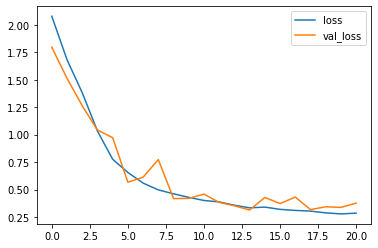

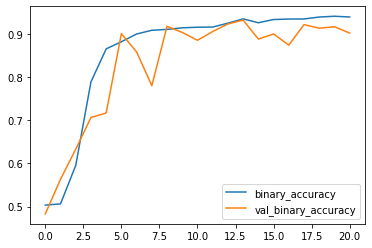

In [ ]:
#plot loss
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

# #determine best epoch
val_acc_per_epoch = history.history['val_binary_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Confusion Matrix

loss :  0.4267996847629547
tp :  1279.0
fp :  149.0
tn :  1279.0
fn :  149.0
accuracy :  0.8956582546234131
precision :  0.8956582546234131
recall :  0.8956582546234131
auc :  0.9577040076255798
prc :  0.9526682496070862
binary_accuracy :  0.8956582546234131

Normal ECG Detected (True Negatives):  1305
Normal ECG Incorrectly Detected (False Positives):  1
AFIB ECG Missed (False Negatives):  122
AFIB ECG Detected (True Positives):  0
Total ECG AFIB:  122


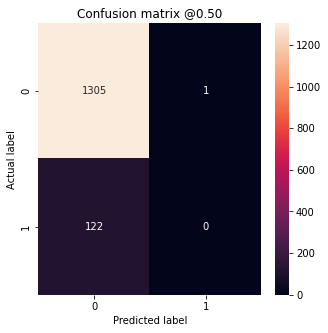

In [ ]:
#get best model from Training
model=load_model('/content/drive/My Drive/best_model.h5')

#train_predictions_baseline = model.predict(X_train_std,verbose=0)
test_predictions_baseline = model.predict(X_val,verbose=0)

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Normal ECG Detected (True Negatives): ', cm[0][0])
  print('Normal ECG Incorrectly Detected (False Positives): ', cm[0][1])
  print('AFIB ECG Missed (False Negatives): ', cm[1][0])
  print('AFIB ECG Detected (True Positives): ', cm[1][1])
  print('Total ECG AFIB: ', np.sum(cm[1]))

baseline_results = model.evaluate(X_val_std, Y_val,verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(Y_val.argmax(axis=1), test_predictions_baseline.argmax(axis=1))
#plot_cm(Y_train.argmax(axis=1), train_predictions_baseline.argmax(axis=1))

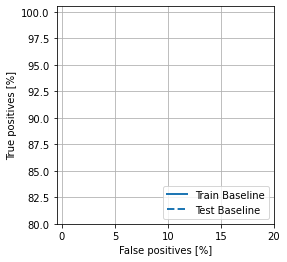

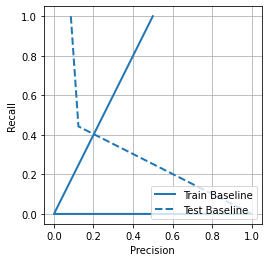

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
plot_roc("Train Baseline", Y_train.argmax(axis=1), train_predictions_baseline.argmax(axis=1), color=colors[0])
plot_roc("Test Baseline", Y_val.argmax(axis=1), test_predictions_baseline.argmax(axis=1), color=colors[0], linestyle='--')
plt.legend(loc='lower right');
plt.show()

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
plot_prc("Train Baseline", Y_train.argmax(axis=1), train_predictions_baseline.argmax(axis=1), color=colors[0])
plot_prc("Test Baseline", Y_val.argmax(axis=1), test_predictions_baseline.argmax(axis=1), color=colors[0], linestyle='--')
plt.legend(loc='lower right');

Save Model 

In [ ]:
model.save('bad_CNN_model')